### Data Preparation & Splitting

In [7]:
import json
from collections import defaultdict
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split

# --- Step 1: Compute Page-Level Error Rates ---
labels_path = "../../data/word_level_labels.jsonl"
page_labels = defaultdict(list)
with open(labels_path, "r", encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)
        page_labels[row["file_id"]].append(row["label"])

error_rates = {
    file_id: sum(1 for l in labels if l == "error") / len(labels)
    for file_id, labels in page_labels.items() if labels
}
pd.DataFrame(
    [{"file_id": fid, "error_rate": rate} for fid, rate in error_rates.items()]
).to_csv("../../data/page_error_rates.csv", index=False)

# --- Step 2: Create DataFrame with XML Paths and Error Rates ---
input_dir = Path("../../data/d2_0001-0100_without_marginalia")
xml_files = sorted(list(input_dir.glob("*.xml")))
df_error = pd.read_csv("../../data/page_error_rates.csv")
df_files = pd.DataFrame({
    "file_path": [str(f) for f in xml_files],
    "file_id": [f.stem for f in xml_files]
}).merge(df_error, on="file_id", how="left")

# --- Step 3: Train/Test Split ---
train_df, test_df = train_test_split(
    df_files.dropna(), test_size=0.20, random_state=42, shuffle=True
)

### Feature Extraction

In [8]:
from sentence_transformers import SentenceTransformer
from extract_features import extract_filtered_features_from_page
from src.evaluator.page_parser import parse_raw_page_from_xml, Page

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

def extract_filtered_features_from_xml(xml_path: str, embedder) -> np.ndarray:
    page = parse_raw_page_from_xml(Path(xml_path))
    return extract_filtered_features_from_page(page, embedder)

# --- Step 5: Feature Extraction (Training & Test Sets) ---
X_train = np.array([
    extract_filtered_features_from_xml(fp, model)
    for fp in tqdm(train_df["file_path"], desc="Extracting train features")
])
X_test = np.array([
    extract_filtered_features_from_xml(fp, model)
    for fp in tqdm(test_df["file_path"], desc="Extracting test features")
])

y_train = train_df["error_rate"].values
y_test = test_df["error_rate"].values

Extracting test features: 100%|████████████████████████████████████████████████████████| 97/97 [00:06<00:00, 15.36it/s]


### Model Training

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

# --- Step 6: Train Regressor with Extended Grid ---
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
joblib.dump(best_model, "./pretrained_weights/rf_regressor.joblib")

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Best Params:", grid_search.best_params_)
print("Test MSE:", mse)
print("\nSample Predictions:")
for i in range(min(10, len(y_test))):
    print(f"{test_df.iloc[i]['file_id']}: True={y_test[i]:.3f}, Pred={y_pred[i]:.3f}")

Fitting 3 folds for each of 135 candidates, totalling 405 fits
Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}
Test MSE: 0.020234675352626595

Sample Predictions:
174169776X_00000016: True=1.000, Pred=0.985
1744303657_00000062: True=0.013, Pred=0.016
1738572234_00000247: True=0.262, Pred=0.057
1741704316_00000021: True=1.000, Pred=0.998
1741193575_00000028: True=1.000, Pred=0.514
1737394219_00000061: True=0.007, Pred=0.016
1740406060_00000083: True=0.000, Pred=0.017
1740400666_00000074: True=0.008, Pred=0.017
1744303878_00000010: True=1.000, Pred=0.992
1739048040_00000011: True=0.040, Pred=0.016


### Internal Evaluation & Visualization

Test MSE : 0.0202
Test RMSE: 0.1422
Test MAE : 0.0644


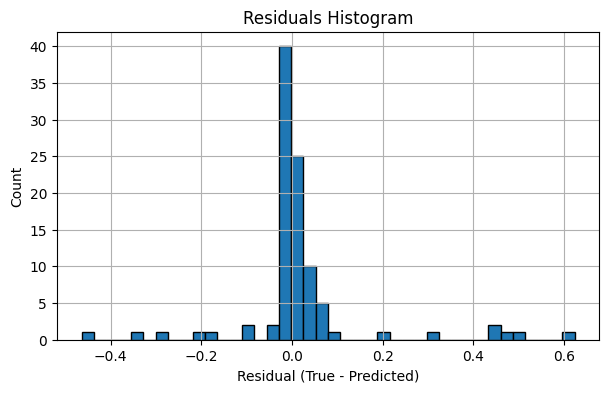

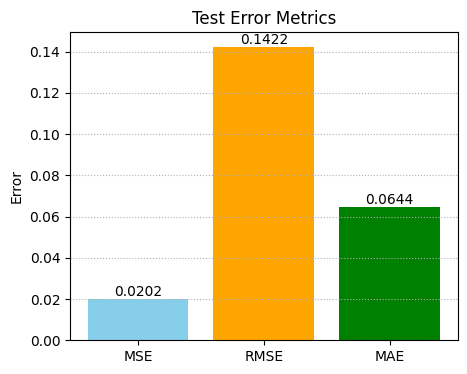

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# --- Compute metrics ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE : {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# --- Histogram of residuals ---
residuals = y_test - y_pred
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=40, edgecolor='k')
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.grid(True)
plt.show()

# --- Bar chart: MSE, RMSE, MAE ---
plt.figure(figsize=(5,4))
plt.bar(["MSE", "RMSE", "MAE"], [mse, rmse, mae], color=['skyblue','orange','green'])
plt.title("Test Error Metrics")
plt.ylabel("Error")
for i, v in enumerate([mse, rmse, mae]):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
plt.grid(True, axis='y', linestyle=':')
plt.show()

### External Evaluation

rmse      : 0.1181
spearman_r: 0.6214
spearman_p: 1.954e-33
pearson_r : 0.9043
pearson_p : 3.64e-112
mean_1    : 0.1078
mean_2    : 0.2558
n_pages   : 300


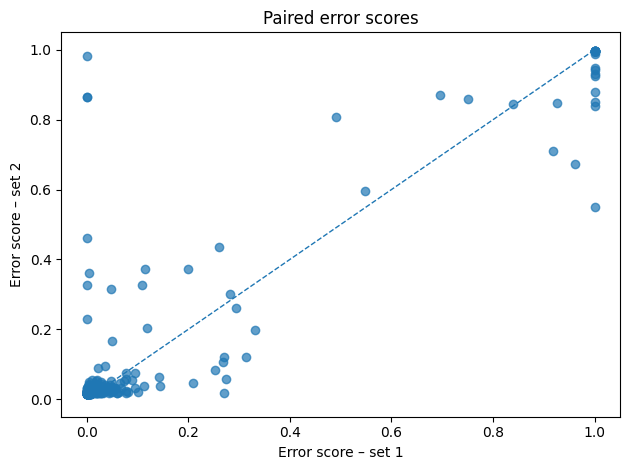

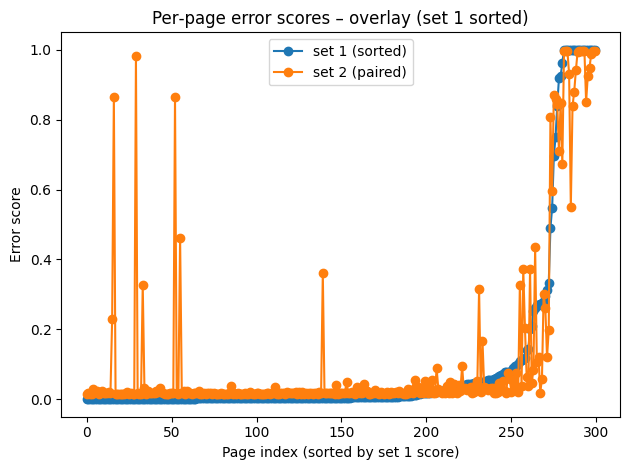

In [12]:
import joblib
from pathlib import Path
from sentence_transformers import SentenceTransformer

from src.evaluator.evaluation import (
    calculate_annotated_pages_with_pred_scorer,
    calulate_statistics_for_page_sets,
)
from src.evaluator.page_parser import Page, load_pages
from extract_features import extract_filtered_features_from_page

# --- Page-level scorer using the trained regressor ---
class FinalRegressorPageScorer:
    def __init__(self, regressor, embedder):
        self.regressor = regressor
        self.embedder = embedder

    def calculate_detailed_error_scores(self, pred_page: Page) -> Page:
        features = extract_filtered_features_from_page(pred_page, self.embedder)
        error_rate = float(self.regressor.predict([features])[0])
        pred_page.overwrite_page_error = error_rate
        return pred_page

if __name__ == "__main__":
    # Load trained regressor and embedder
    regressor = joblib.load("./pretrained_weights/rf_regressor.joblib")
    model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

    # Dataset path for external/manual annotation
    dataset_path = Path("../../data")

    # Create scorer instance
    pred_scorer = FinalRegressorPageScorer(regressor, model)

    # Annotate pages using predicted scorer
    pred_annotated_pages = calculate_annotated_pages_with_pred_scorer(
        dataset_path, pred_scorer
    )

    # Load manually annotated pages for evaluation
    manually_annotated_pages = load_pages(Path("../../data/manual_annotation_approach"))

    # Evaluate and visualize statistics (e.g., RMSE, Spearman, Pearson)
    calulate_statistics_for_page_sets(manually_annotated_pages, pred_annotated_pages, True)

### Save Predicted Pages to XML

In [15]:
from src.evaluator.page_parser import save_pages
from pathlib import Path

# Specify output folder for predicted XMLs
output_folder = Path("../../data/predicted_xml")

# Save the predicted pages as XML files
written_files = save_pages(pred_annotated_pages, output_folder)

print(f"Saved {len(written_files)} predicted page XMLs to: {output_folder.resolve()}")

Saved 493 predicted page XMLs to: C:\Users\arsla\Desktop\Praktikum - NLP\llms-ocr\data\predicted_xml


### Display Top Page-Level Prediction Errors

In [13]:
from operator import attrgetter

# Step 1: Sort both lists by page name to align
manual_sorted = sorted(manually_annotated_pages, key=attrgetter("name"))
pred_sorted = sorted(pred_annotated_pages, key=attrgetter("name"))

# Step 2: Compute absolute differences
differences = []
for manual_page, pred_page in zip(manual_sorted, pred_sorted):
    manual_score = manual_page.overwrite_page_error
    pred_score = pred_page.overwrite_page_error
    diff = abs(manual_score - pred_score)
    differences.append((manual_page.name, manual_score, pred_score, diff))

# Step 3: Sort by difference descending and get top 20
top_diff = sorted(differences, key=lambda x: x[3], reverse=True)[:20]

# Step 4: Print results
print(f"{'Page Name':<40} | {'Manual Score':<13} | {'Predicted':<10} | {'Abs Diff':<10}")
print("-" * 85)
for name, manual, pred, diff in top_diff:
    print(f"{name:<40} | {manual:<13.4f} | {pred:<10.4f} | {diff:<10.4f}")

Page Name                                | Manual Score  | Predicted  | Abs Diff  
-------------------------------------------------------------------------------------
1740361105_00000002                      | 0.0000        | 0.9978     | 0.9978    
1740384288_00000002                      | 1.0000        | 0.0163     | 0.9837    
1740388542_00000002                      | 1.0000        | 0.0166     | 0.9834    
1737364816_00000001                      | 0.0000        | 0.9810     | 0.9810    
1740257367_00000077                      | 1.0000        | 0.0234     | 0.9766    
1740388542_00000039                      | 0.0000        | 0.9493     | 0.9493    
1740384288_00000128                      | 0.0038        | 0.9256     | 0.9218    
1737391953_00000035                      | 0.0000        | 0.8659     | 0.8659    
1740257367_00000029                      | 0.0022        | 0.8065     | 0.8043    
1740361105_00000021                      | 0.1435        | 0.8659     | 0.7224    
1